<h1 align=center><font size = 5>North America City Comparation</font></h1>

<a id='Top'></a>

## Table of Contents

1. [Introduction](#Introduction) <br/>
&nbsp; 1.1 [Background](#Backgound) <br/>
&nbsp; 1.2 [Target Audience](#Target) <br/>
2. [Data](#Data)<br/>
&nbsp; 2.1 [City Climate Data](#CityClimateData) <br/>
&nbsp; 2.2 [Demographic Data](#Demographic) <br/>
&nbsp; 2.3 [Geolocation Data](#Geolocation) <br/>
&nbsp; 2.4 [Foursquare Data](#CityVenue) <br/>
3. [Analyze Data](#AnalyzeData)<br/>
&nbsp; 3.1 [Analyze Climate Data](#AnalyzeClimate) <br/>
&nbsp; 3.2 [Analyze Demographic Data](#AnalyzeDemographic) <br/>
&nbsp; 3.3 [Analyze City Venues Data](#AnalyzeCityVenues) <br/>
&nbsp; 3.4 [Analyze Combined Climate, Demographic and Venues Data](#AnalyzeCombine) <br/>
4. [Conclusion](#Conclusion)<br/>

<a id='Introduction'></a>
## 1 Introduction

<a id='Background'></a>
#### 1.1 Background 

As the evolvement of globalization, it becomes more and more common for people to relocate among cities and countries. 

One major part of people's life is eating and entertaining. It is crucially important for people to have access to places they enjoy. Also, the weather and culture differs in different cities are important factors as well. It is helpful for people interested in moving to have a tool to compare the similarities among cities. 

Therefore, I am going to use data like venues types, restaurant quantity, climate data, demographics, etc. And create a tool to directly compare cities and cluster similar into groups. Hope it would be helpful for those people.

Particularly, I am going to cluster cities in North America into several groups.

<a id='Target'></a>
#### 1.2 Stakeholder/Target Audience

The target audience is those who are currently searching for new cities to moving. Or someone wants to compare the living environment between different cities/neighborhoods.  Or someone who is curious about smililarities among different cities. 

<a id='Data'></a>
## 2 Data

[Back to Top](#Top)

- Foursquare Data
- Climate data
- Demographic

#### Load Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import sys, collections
import folium

from scipy.cluster import hierarchy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from pprint import pprint
from pathlib import Path # File path checking
from bs4 import BeautifulSoup # HTML Parser

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut

<a id='CityClimateData'></a>
#### 2.1 City Climate Data

[Back to Top](#Top)

In [2]:
cities={
    "New York City": "https://en.wikipedia.org/wiki/New_York_City",
    "Toronto": "https://en.wikipedia.org/wiki/Toronto",
    "Vancouver": "https://en.wikipedia.org/wiki/Vancouver",
    "Boston": "https://en.wikipedia.org/wiki/Boston",
    "Montreal": "https://en.wikipedia.org/wiki/Montreal",
    "San Francisco": "https://en.wikipedia.org/wiki/San_Francisco",
    "Seattle": "https://en.wikipedia.org/wiki/Seattle",
    "Edmonton": "https://en.wikipedia.org/wiki/Edmonton",
    "Calgary": "https://en.wikipedia.org/wiki/Calgary",
    "Los Angeles": "https://en.wikipedia.org/wiki/Los_Angeles",
    "Chicago": "https://en.wikipedia.org/wiki/Chicago",
    "Houston": "https://en.wikipedia.org/wiki/Houston",
}

In [3]:
def read_file(file):
    with open(file) as f:
        content = f.read()
    return content

def write_file(file, content):
    with open(file, 'w') as f:
        f.write(content)
    

def get_page_content(name, url):
    """
    Get web page content and cache it locally
    """
    storage_path = "./data"
    suffix = ".html"  
    file_path = storage_path + '/' + name + suffix
    
    file = Path(file_path)
    if file.exists():
        content = read_file(file)
    else:
        content = requests.get(url).text
        write_file(file_path, content)
    
    return content

In [4]:
def parse_climate_data(page_content):
    """
    parse wikipedia climate data
    """   
    # Parse HTML file
    soup = BeautifulSoup(page_content, 'lxml')
    
    tables = soup.find_all('table')
    # ad-hoc to select Chicago's second table
    chicago_skip_first = False
    
    for table in tables:   
        # Only select Climate data
        if table.tbody.tr.text.find('Climate data') == -1:
            continue
        
        # skip Chicago's first table
        if table.tbody.tr.text.find("Chicago") != -1 and chicago_skip_first == False:
            chicago_skip_first=True
            continue
    
    return pd.read_html(str(table))[0]

In [5]:
def climate_celsius_to_fahrenheit(df):
    """
    convert celsius to fahrenheit.
    """
    def extract_from_bracket(val):
        """
        extract number inside bracket '−0.7(30.7)' -> 30.7
        """
        try:
            found = re.search('\((.+?)\)', val).group(1)
        except AttributeError:
            found = val
        return found
    
    def extract_preceed_bracket(val):
        """
        extract number before bracket '−0.7(30.7)' -> -0.7
        """
        try:
            found = re.search('(.+?)\(.+', val).group(1)
        except AttributeError:
            found = val
        return found
        
    is_celsius = df.index.str.contains("°C \(°F\)").any()
    if is_celsius:
        df_proc = df.applymap(extract_from_bracket)
    else:
        df_proc = df.applymap(extract_preceed_bracket)
        
    return df_proc

In [6]:
def process_climate_table(page_content):
    """
    process wikipedia climate table
    """
    # Get climate data table
    df = parse_climate_data(page_content)
    
    # rename header
    header = df.iloc[1]
    df.rename(columns=header, inplace=True)
    
    # using first column as index
    df.set_index("Month", inplace=True)
    
    # drop extra data
    df=df.iloc[2:-2,:]
    
    index_col = df.index
    
    # get target rows
    avg_high_filter = index_col.str.contains("average high", case=False)==True
    avg_low_filter = index_col.str.contains("average low", case=False)==True
    # select precipitation days or rainy days
    rainy_filter = index_col.str.contains("precipitation days", case=False)==True
    if rainy_filter.any() == False:
        rainy_filter = index_col.str.contains("rainy days", case=False)==True
    sunshine_filter = index_col.str.contains("monthly sunshine hours")==True
    
    df = df[avg_high_filter|avg_low_filter|rainy_filter|sunshine_filter]
    
#     print(df)
    # Convert the first two rows if needed
    df_high_low = climate_celsius_to_fahrenheit(df.iloc[:2])
    df = pd.concat([df_high_low,df[2:]])
    
    # rename index/column
    df['Type'] = pd.Series(["Average high °F", "Average low °F", "Average precipitation days", "Mean monthly sunshine hours"], index=df.index)
    df.set_index("Type", inplace=True)
    df.columns.names =['Month']
#     df.rename_axis(index=["Average high °F", "Average low °F", "Average precipitation days", "Mean monthly sunshine hours"], inplace=True)

    return df

Single City Test 

In [7]:
city="Edmonton"
city_page_content = get_page_content(city, cities[city])
df = process_climate_table(city_page_content)
city_data =  np.reshape(df.values,(1,-1))
city_data
# print(df.iloc[:, -2:])

array([['21.2', '27.1', '36.0', '52.2', '63.5', '69.8', '73.6', '72.7',
        '62.8', '50.7', '32.0', '23.9', '48.7', '5.4', '9.5', '19.0',
        '31.1', '41.7', '49.8', '54.1', '52.3', '42.4', '31.6', '17.2',
        '8.4', '30.2', '11.0', '7.9', '8.3', '8.8', '11.0', '14.2',
        '14.6', '11.1', '9.8', '8.0', '8.8', '9.4', '122.9', '100.8',
        '121.7', '176.3', '244.2', '279.9', '285.9', '307.5', '282.3',
        '192.7', '170.8', '98.4', '84.5', '2344.8']], dtype=object)

In [8]:
df_climate = pd.DataFrame()
for city in cities.keys():
    city_page_content = get_page_content(city, cities[city])
    df = process_climate_table(city_page_content)
    city_data =  np.reshape(df.values,(1,-1))
    print("== Processing {} ==".format(city))
    col_length = city_data.shape[1]
    
    # construct dataframe
    city_df = pd.DataFrame(data=city_data, index=[city], columns=[str(i) for i in range(col_length)])   
    df_climate = df_climate.append(city_df)


print(df_climate.shape)
df_climate

== Processing New York City ==
== Processing Toronto ==
== Processing Vancouver ==
== Processing Boston ==
== Processing Montreal ==
== Processing San Francisco ==
== Processing Seattle ==
== Processing Edmonton ==
== Processing Calgary ==
== Processing Los Angeles ==
== Processing Chicago ==
== Processing Houston ==
(12, 52)


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
New York City,38.3,41.6,49.7,61.2,70.8,79.3,84.1,82.6,75.2,63.8,...,225.6,256.6,257.3,268.2,268.2,219.3,211.2,151.0,139.0,2534.7
Toronto,30.7,32.7,40.5,52.7,65.1,74.8,79.9,77.9,69.8,57.2,...,180.0,227.7,259.6,279.6,245.6,194.4,154.3,88.9,78.1,2066.3
Vancouver,44.4,46.8,50.5,55.8,62.1,67.3,72.0,72.0,66.0,56.3,...,185.0,222.5,226.9,289.8,277.1,212.8,120.7,60.4,56.5,1937.5
Boston,35.8,38.7,45.4,55.6,66.0,75.9,81.4,79.6,72.4,61.4,...,227.2,267.3,286.5,300.9,277.3,237.1,206.3,143.2,142.3,2633.6
Montreal,22.5,26.2,36.5,52.9,66.0,75.0,79.3,77.5,69.1,55.4,...,178.3,228.9,240.3,271.5,246.3,182.2,143.5,83.6,83.6,2051.3
San Francisco,56.9,60.2,61.8,63.1,64.3,66.4,66.5,68.1,70.2,69.2,...,309.3,325.1,311.4,313.3,287.4,271.4,247.1,173.4,160.6,3061.7
Seattle,47.2,49.9,53.7,58.5,64.7,69.9,75.8,76.3,70.5,59.7,...,207.3,253.7,268.4,312.0,281.4,221.7,142.6,72.7,52.9,2169.7
Edmonton,21.2,27.1,36.0,52.2,63.5,69.8,73.6,72.7,62.8,50.7,...,244.2,279.9,285.9,307.5,282.3,192.7,170.8,98.4,84.5,2344.8
Calgary,30.4,33.3,39.9,52.2,61.3,67.6,73.8,73.0,64.0,53.1,...,220.2,249.4,269.9,314.1,284.0,207.0,175.4,121.1,114.0,2396.3
Los Angeles,68.2,68.6,70.2,72.7,74.5,78.1,83.1,84.4,83.1,78.5,...,303.5,276.2,275.8,364.1,349.5,278.5,255.1,217.3,219.4,3254.2


Climate Data: df_climate

<a id='Demographic'></a>
#### 2.2 Demographic Data Process

[Back to Top](#Top)

Since some city's demographic data are not show in Table(unstructured data), we have to manually input

In [9]:
df_demographic = pd.read_csv('./data/demographic.csv', index_col=0)
print(df_demographic.shape)
df_demographic

(12, 4)


,White,Black,Asian,Hispanics
New York City,44.0,25.5,12.7,28.6
Toronto,47.9,5.5,40.1,4.2
Vancouver,47.2,1.0,50.6,1.7
Boston,43.9,23.1,9.7,20.4
San Francisco,48.5,6.1,33.3,15.1
Seattle,69.5,7.9,13.8,6.6
Edmonton,55.8,6.1,25.4,2.3
Calgary,59.5,5.4,28.2,2.6
Los Angeles,28.7,9.6,11.3,48.5
Chicago,44.9,32.9,5.5,28.9


<a id='Geolocation'></a>
#### 2.3 Geolocation Data

[Back to Top](#Top)

In [10]:
geolocator = Nominatim(user_agent="city_explorer")

def do_geocode(address, counter=0):
    if counter >= 10:
        print("## Check Your Network, geocoder failed {} times".format(counter))
        return GeocoderTimedOut
    
    try:
        print("## do_geocode try address {} the {} time".format(address, counter+1))
        location = geolocator.geocode(address, timeout=3)
        return location.latitude, location.longitude
    except GeocoderTimedOut:
        time.sleep(2)
        return do_geocode(address, counter+1)

In [11]:
city_names = list(cities.keys())
df_geolocation = pd.DataFrame()
city_geolocation = dict()

# Read from local
local_geo_cache = './data/geolocation.csv'
df_geolocation = pd.read_csv(local_geo_cache, index_col=0)
df_geolocation

,latitude,longitude
New York City,40.712728,-74.006015
Toronto,43.653963,-79.387207
Vancouver,49.260872,-123.113953
Boston,42.360253,-71.058291
Montreal,45.497216,-73.610364
San Francisco,37.779281,-122.419236
Seattle,47.603832,-122.330062
Edmonton,53.535411,-113.507996
Calgary,51.025327,-114.049868
Los Angeles,34.053691,-118.242767


In [12]:
# for city in city_names:
#     latitude, longitude = do_geocode(city)
#     print('The geograpical coordinate of {} are {}, {}.'.format(city, latitude, longitude))
    
#     city_geolocation[city] = (latitude, longitude)
    
#     city_df = pd.DataFrame(data=[[latitude, longitude]], index=[city], columns=["latitude", "longitude"])   
#     df_geolocation = df_geolocation.append(city_df)
    
print("\n#### Geolocation Finished ####\n")


#### Geolocation Finished ####



In [13]:
# df_geolocation.to_csv('./data/geolocation.csv')
pprint(df_geolocation)

                latitude   longitude
New York City  40.712728  -74.006015
Toronto        43.653963  -79.387207
Vancouver      49.260872 -123.113953
Boston         42.360253  -71.058291
Montreal       45.497216  -73.610364
San Francisco  37.779281 -122.419236
Seattle        47.603832 -122.330062
Edmonton       53.535411 -113.507996
Calgary        51.025327 -114.049868
Los Angeles    34.053691 -118.242767
Chicago        41.875562  -87.624421
Houston        29.758938  -95.367697


In [14]:
df_climate_bk = df_climate.copy()
df_demographic_bk = df_demographic.copy()
df_geolocation_bk = df_geolocation.copy()

<a id='CityVenue'></a>
#### 2.4 City Venue Data From Foursquare

[Back to Top](#Top)

In [15]:
# import Foursquare credential
from credential import *

LIMIT = 100
CLIENT_ID = FS_ID # Foursquare ID
CLIENT_SECRET = FS_SECRET # Foursquare Secret
VERSION = FS_VERSION
Local_Cache = './data/city_venue_data.json'

In [16]:
def read_json(file):
    fp=open(file,'r+')
    res_dict=json.load(fp)
    fp.close()
    return {} if isinstance(res_dict, collections.Mapping) == False else res_dict

def write_json(file, content):
    fp= open(file, 'w+')
    json.dump(content,fp)
    fp.truncate()
    fp.close()

# write_json(Local_Cache, dict()) # Initialize file

In [17]:
def getCityNearbyVenues(cities, latitudes, longitudes, force_update=False, radius=10000):
    venues_dict = read_json(Local_Cache)
    venues_list=[]
    for city, lat, lng in zip(cities, latitudes, longitudes):
        store_key = city
        if store_key in venues_dict and force_update == False:
            print('Already exist in cache, Processing: ' + str(store_key))
            results=venues_dict[store_key]
        else:
            print('Fetching: ' + str(store_key))

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                'browse')
            print(url)
            try:
                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']
                venues_dict[store_key]=results
            except:
                error = sys.exc_info()[0]
                print("Error fetching" + str(city) + " " + str(error))
                continue

        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    write_json(Local_Cache, venues_dict)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
df_geolocation

,latitude,longitude
New York City,40.712728,-74.006015
Toronto,43.653963,-79.387207
Vancouver,49.260872,-123.113953
Boston,42.360253,-71.058291
Montreal,45.497216,-73.610364
San Francisco,37.779281,-122.419236
Seattle,47.603832,-122.330062
Edmonton,53.535411,-113.507996
Calgary,51.025327,-114.049868
Los Angeles,34.053691,-118.242767


In [19]:
# df_test=df_geolocation.iloc[:1,:]

city_venues = getCityNearbyVenues(cities=df_geolocation.index.to_series(),
                                  latitudes=df_geolocation['latitude'],
                                  longitudes=df_geolocation['longitude'],
                                  force_update=False)
city_venues

Already exist in cache, Processing: New York City
Already exist in cache, Processing: Toronto
Already exist in cache, Processing: Vancouver
Already exist in cache, Processing: Boston
Already exist in cache, Processing: Montreal
Already exist in cache, Processing: San Francisco
Already exist in cache, Processing: Seattle
Already exist in cache, Processing: Edmonton
Already exist in cache, Processing: Calgary
Already exist in cache, Processing: Los Angeles
Already exist in cache, Processing: Chicago
Already exist in cache, Processing: Houston


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,New York City,40.712728,-74.006015,Four Seasons Hotel New York Downtown,40.712612,-74.009380,Hotel
2,New York City,40.712728,-74.006015,Korin,40.714824,-74.009404,Furniture / Home Store
3,New York City,40.712728,-74.006015,Aire Ancient Baths,40.718141,-74.004941,Spa
4,New York City,40.712728,-74.006015,9/11 Memorial North Pool,40.712077,-74.013187,Memorial Site
5,New York City,40.712728,-74.006015,One World Trade Center,40.713069,-74.013133,Building
6,New York City,40.712728,-74.006015,Washington Market Park,40.717046,-74.011095,Playground
7,New York City,40.712728,-74.006015,Crown Shy,40.706187,-74.007490,Restaurant
8,New York City,40.712728,-74.006015,Liberty Park,40.710384,-74.013868,Park
9,New York City,40.712728,-74.006015,sweetgreen,40.705586,-74.008382,Salad Place


In [20]:
df_venues = city_venues.copy()
df_venues_bk = city_venues.copy()
df_venues

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,New York City,40.712728,-74.006015,Four Seasons Hotel New York Downtown,40.712612,-74.009380,Hotel
2,New York City,40.712728,-74.006015,Korin,40.714824,-74.009404,Furniture / Home Store
3,New York City,40.712728,-74.006015,Aire Ancient Baths,40.718141,-74.004941,Spa
4,New York City,40.712728,-74.006015,9/11 Memorial North Pool,40.712077,-74.013187,Memorial Site
5,New York City,40.712728,-74.006015,One World Trade Center,40.713069,-74.013133,Building
6,New York City,40.712728,-74.006015,Washington Market Park,40.717046,-74.011095,Playground
7,New York City,40.712728,-74.006015,Crown Shy,40.706187,-74.007490,Restaurant
8,New York City,40.712728,-74.006015,Liberty Park,40.710384,-74.013868,Park
9,New York City,40.712728,-74.006015,sweetgreen,40.705586,-74.008382,Salad Place


<a id='AnalyzeData'></a>

## 3. Analyze Data

[Back to Top](#Top)

Matplot customize
```python
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGER_SIZE = 12


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGER_SIZE)  # fontsize of the figure title
```

In [21]:
SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGER_SIZE = 14

General function to plot North America Map with labels.

In [22]:
def plot_north_america_map(df_geo, df_labels, key):
    # make a local copy
    df_cluster = df_geo.copy() 
    df_cluster = df_cluster.join(df_labels) # join dataframe by index
    # print(df_cluster)
    north_america_loc = [40.92474, -98.3399] # Grand Island, NE, US
    
    # Create map
    map_clusters = folium.Map(location=north_america_loc, zoom_start=5)
    
    # Initialize color
    colormap = cm.rainbow(np.linspace(0, 1, len(set(df_labels[key]))))
    rainbow = [colors.rgb2hex(i) for i in colormap]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_cluster['latitude'], df_cluster['longitude'], df_cluster.index.to_series(), df_cluster[key]):
        label = folium.Popup(str(poi) + '\nCluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=8,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.8).add_to(map_clusters)

    return map_clusters

In [23]:
def cluster_n_draw_map(df, n_cluster=4, print_cluster=True):
    cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='ward')
    cluster.fit(df)
    
    if print_cluster:
        print(pd.DataFrame(cluster.labels_, index=df.index, columns=['Cluster']))

    demo_key = 'Cluster'
    df_cl = df.copy()
    df_cl.insert(0, demo_key, cluster.labels_)

    return plot_north_america_map(df_geolocation, df_cl, demo_key)

<a id='AnalyzeClimate'></a>
#### 3.1 Analyze Climate Data

[Back to Top](#Top)

We have climate data: df_climate

First look at the data

In [24]:
df_climate

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
New York City,38.3,41.6,49.7,61.2,70.8,79.3,84.1,82.6,75.2,63.8,...,225.6,256.6,257.3,268.2,268.2,219.3,211.2,151.0,139.0,2534.7
Toronto,30.7,32.7,40.5,52.7,65.1,74.8,79.9,77.9,69.8,57.2,...,180.0,227.7,259.6,279.6,245.6,194.4,154.3,88.9,78.1,2066.3
Vancouver,44.4,46.8,50.5,55.8,62.1,67.3,72.0,72.0,66.0,56.3,...,185.0,222.5,226.9,289.8,277.1,212.8,120.7,60.4,56.5,1937.5
Boston,35.8,38.7,45.4,55.6,66.0,75.9,81.4,79.6,72.4,61.4,...,227.2,267.3,286.5,300.9,277.3,237.1,206.3,143.2,142.3,2633.6
Montreal,22.5,26.2,36.5,52.9,66.0,75.0,79.3,77.5,69.1,55.4,...,178.3,228.9,240.3,271.5,246.3,182.2,143.5,83.6,83.6,2051.3
San Francisco,56.9,60.2,61.8,63.1,64.3,66.4,66.5,68.1,70.2,69.2,...,309.3,325.1,311.4,313.3,287.4,271.4,247.1,173.4,160.6,3061.7
Seattle,47.2,49.9,53.7,58.5,64.7,69.9,75.8,76.3,70.5,59.7,...,207.3,253.7,268.4,312.0,281.4,221.7,142.6,72.7,52.9,2169.7
Edmonton,21.2,27.1,36.0,52.2,63.5,69.8,73.6,72.7,62.8,50.7,...,244.2,279.9,285.9,307.5,282.3,192.7,170.8,98.4,84.5,2344.8
Calgary,30.4,33.3,39.9,52.2,61.3,67.6,73.8,73.0,64.0,53.1,...,220.2,249.4,269.9,314.1,284.0,207.0,175.4,121.1,114.0,2396.3
Los Angeles,68.2,68.6,70.2,72.7,74.5,78.1,83.1,84.4,83.1,78.5,...,303.5,276.2,275.8,364.1,349.5,278.5,255.1,217.3,219.4,3254.2


Plot the dendrogram for Climate data to get a more intuitive understanding

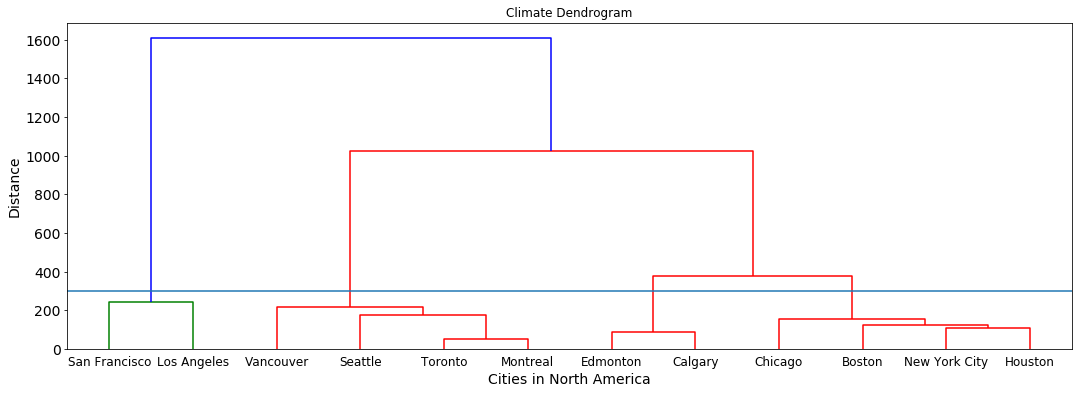

In [25]:
plt.figure(figsize=(18,6))
plt.rc('ytick', labelsize=BIGER_SIZE)    # fontsize of the tick labels
plt.rc('axes', labelsize=BIGER_SIZE)
climate_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(df_climate, method="ward"),
    labels=df_climate.index
)

plt.title("Climate Dendrogram")
plt.xlabel("Cities in North America")
plt.ylabel("Distance")
plt.axhline(y=300) # Add a line to show which distance

As the line with distance 300 shows, it makes sense to cluster Cities into 4 groups

In [26]:
cluster_n_draw_map(df_climate, 4)

               Cluster
New York City        1
Toronto              2
Vancouver            2
Boston               1
Montreal             2
San Francisco        0
Seattle              2
Edmonton             3
Calgary              3
Los Angeles          0
Chicago              1
Houston              1


<a id='AnalyzeDemographic'></a>
#### 3.2 Analyze Demographic Data  

[Back to Top](#Top)

We have demographic data df_demographic

Let's first look at the data

In [27]:
df_demographic

,White,Black,Asian,Hispanics
New York City,44.0,25.5,12.7,28.6
Toronto,47.9,5.5,40.1,4.2
Vancouver,47.2,1.0,50.6,1.7
Boston,43.9,23.1,9.7,20.4
San Francisco,48.5,6.1,33.3,15.1
Seattle,69.5,7.9,13.8,6.6
Edmonton,55.8,6.1,25.4,2.3
Calgary,59.5,5.4,28.2,2.6
Los Angeles,28.7,9.6,11.3,48.5
Chicago,44.9,32.9,5.5,28.9


Plot the dendrogram of Demographic Data

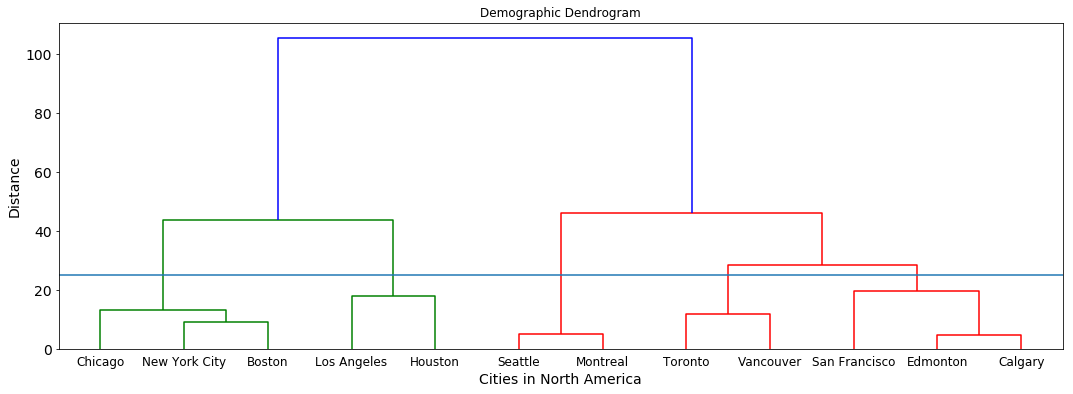

In [28]:
plt.figure(figsize=(18,6))
demographic_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(df_demographic, method="ward"),
    labels=df_demographic.index
)

plt.title("Demographic Dendrogram")
plt.xlabel("Cities in North America")
plt.ylabel("Distance")
plt.axhline(y=25) # Add a line to show which distance

In [29]:
cluster_n_draw_map(df_demographic, 5)

               Cluster
New York City        3
Toronto              4
Vancouver            4
Boston               3
San Francisco        0
Seattle              2
Edmonton             0
Calgary              0
Los Angeles          1
Chicago              3
Houston              1
Montreal             2


<a id='AnalyzeCityVenues'></a>
#### 3.3 Analyze City Venues Data

[Back to Top](#Top)

In [30]:
df_venues.iloc[:3,:]

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,New York City,40.712728,-74.006015,Four Seasons Hotel New York Downtown,40.712612,-74.009380,Hotel
2,New York City,40.712728,-74.006015,Korin,40.714824,-74.009404,Furniture / Home Store


In [31]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 216 uniques categories.


In [32]:
df_venues_oh=pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
df_venues_oh['City'] = df_venues['City']
df_venues_percent = df_venues_oh.groupby(['City']).sum()/df_venues_oh.groupby(['City']).count()
df_venues_percent

,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
City,,,,,,,,,,,,,,,,,,,,,
Boston,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.01,0.00,0.00
Calgary,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.01,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.01
Chicago,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.01,0.00,...,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00
Edmonton,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00
Houston,0.00,0.00,0.02,0.00,0.00,0.01,0.02,0.01,0.00,0.00,...,0.03,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.00,0.00
Los Angeles,0.00,0.00,0.02,0.00,0.00,0.03,0.01,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
Montreal,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.03,0.00,0.00
New York City,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.03,0.00,0.00
San Francisco,0.01,0.01,0.00,0.00,0.00,0.01,0.02,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.05,0.00,0.00


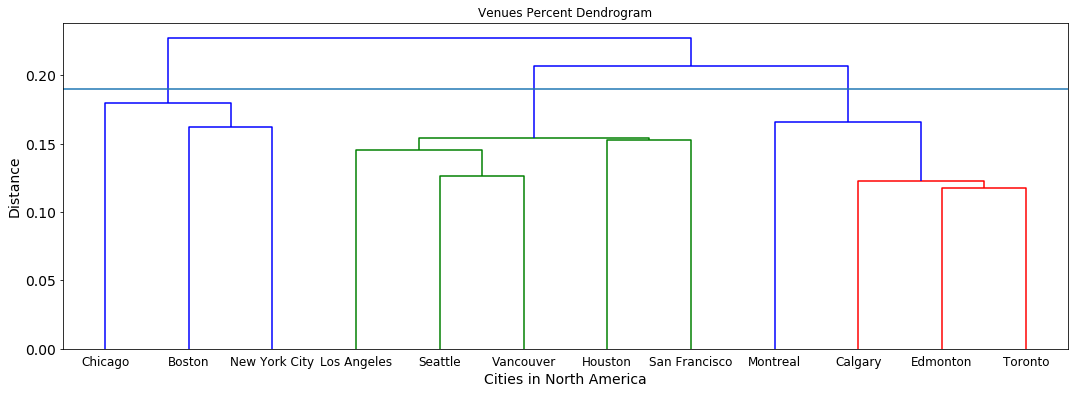

In [33]:
plt.figure(figsize=(18,6))
venues_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(df_venues_percent, method="ward"),
    labels=df_venues_percent.index
)

plt.title("Venues Percent Dendrogram")
plt.xlabel("Cities in North America")
plt.ylabel("Distance")
plt.axhline(y=0.19) # Add a line to show which distance

In [34]:
cluster_n_draw_map(df_venues_percent, 3)

               Cluster
City                  
Boston               0
Calgary              1
Chicago              0
Edmonton             1
Houston              2
Los Angeles          2
Montreal             1
New York City        0
San Francisco        2
Seattle              2
Toronto              1
Vancouver            2


We can see their both geographical and different cultrual influence

<a id='AnalyzeCombine'></a>

#### 3.4: Analyze Combined Climate, Demographic and Venues Data

[Back to Top](#Top)

In [35]:
def scaler_n_pca(df, n_components=4):
    """
    Scale data and do PCA
    """
    scaler = StandardScaler().fit_transform(df)
    pca_comps = PCA(n_components=n_components).fit_transform(scaler)
    return pd.DataFrame(pca_comps, index=df.index)

In [36]:
venues_pca = scaler_n_pca(df_venues_percent,6)
venues_pca

,0,1,2,3,4,5
City,,,,,,
Boston,0.038546,0.741114,-1.265753,3.606738,0.387080,9.702563
Calgary,-6.442783,-1.804313,0.201881,-1.121968,-2.974351,0.050051
Chicago,1.198277,0.438467,-7.386424,12.122351,0.816693,-5.499692
Edmonton,-9.017990,-1.623186,2.951870,-0.616466,-4.964467,-6.303818
Houston,0.305617,-2.994085,-0.779012,-1.864578,2.848691,-1.003893
Los Angeles,6.807514,-11.196614,-6.641630,-4.757850,-3.126238,1.373345
Montreal,-3.444219,2.213647,1.489760,2.141623,-0.106394,4.732623
New York City,7.741903,11.965353,-3.191174,-4.370438,-5.655078,-1.641911
San Francisco,9.084377,-2.726683,13.023704,3.473860,-1.141027,-1.709234


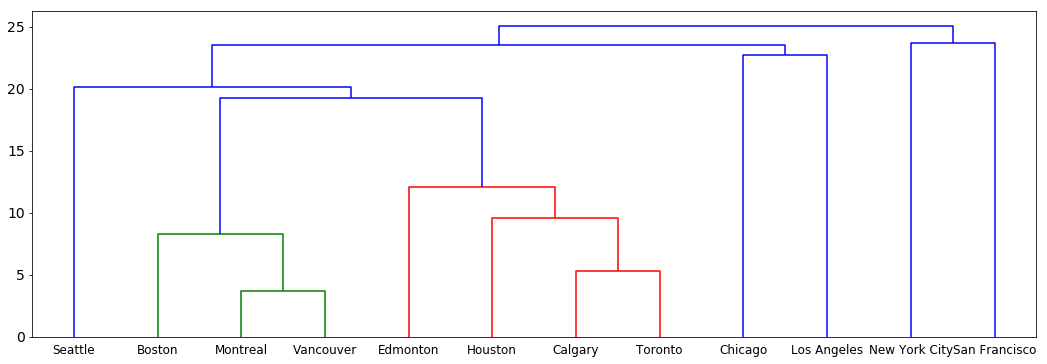

In [37]:
plt.figure(figsize=(18,6))
venues_pca_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(venues_pca, method="ward"),
    labels=venues_pca.index
)

In [38]:
climate_pca = scaler_n_pca(df_climate, 2)
climate_pca

,0,1
New York City,1.299428,1.607032
Toronto,-3.794540,2.271539
Vancouver,-4.433545,3.281282
Boston,0.220786,-0.202619
Montreal,-6.158408,1.702254
San Francisco,6.250404,-3.925456
Seattle,-2.144132,2.043038
Edmonton,-5.401310,-4.206647
Calgary,-4.716284,-5.081080
Los Angeles,11.579126,-2.727884


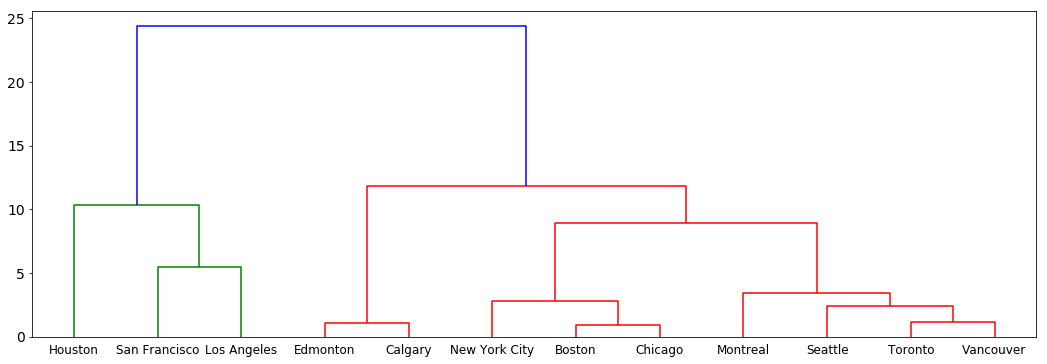

In [39]:
plt.figure(figsize=(18,6))
climate_pca_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(climate_pca, method="ward"),
    labels=climate_pca.index
)

In [40]:
demographic_pca = scaler_n_pca(df_demographic,2)
demographic_pca

,0,1
New York City,1.457176,-0.338840
Toronto,-1.488960,0.879480
Vancouver,-2.140157,1.467906
Boston,1.155234,-0.507140
San Francisco,-0.866138,0.726678
Seattle,-1.146907,-1.432967
Edmonton,-1.300808,-0.211146
Calgary,-1.552972,-0.269522
Los Angeles,1.933231,1.340306
Chicago,2.058868,-0.942446


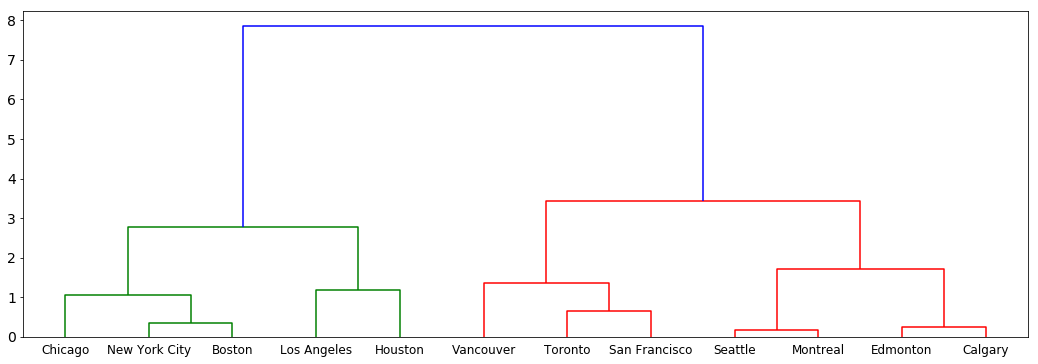

In [41]:
plt.figure(figsize=(18,6))
demographic_pca_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(demographic_pca, method="ward"),
    labels=demographic_pca.index
)

Combine all three data set

In [42]:
combined_pca = pd.concat([venues_pca,climate_pca, demographic_pca], axis=1)
combined_scale = StandardScaler().fit_transform(combined_pca)
df_combined_scale = pd.DataFrame(combined_scale, index=combined_pca.index)
df_combined_scale

,0,1,2,3,4,5,6,7,8,9
Boston,0.007096,0.147022,-0.255521,0.768024,0.086097,2.209175,0.039881,-0.063086,0.689963,-0.531564
Calgary,-1.186127,-0.357938,0.040754,-0.238914,-0.661575,0.011396,-0.851905,-1.582006,-0.927512,-0.282502
Chicago,0.220605,0.086983,-1.491115,2.581352,0.181654,-1.252224,-0.131064,-0.120630,1.229659,-0.987833
Edmonton,-1.660227,-0.322006,0.595901,-0.131271,-1.104229,-1.435315,-0.975642,-1.309749,-0.776908,-0.221315
Houston,0.056265,-0.593964,-0.157261,-0.397046,0.633624,-0.228576,1.449392,1.751662,1.717639,0.671017
Los Angeles,1.253274,-2.221175,-1.340762,-1.013144,-0.695358,0.312697,2.091545,-0.849333,1.154622,1.404854
Montreal,-0.634086,0.439142,0.300741,0.456041,-0.023665,1.077570,-1.112397,0.530001,-0.587981,-1.417630
New York City,1.425297,2.373677,-0.644210,-0.930648,-1.257840,-0.373847,0.234716,0.500353,0.870298,-0.355158
San Francisco,1.672448,-0.540917,2.629126,0.739729,-0.253795,-0.389175,1.129014,-1.222200,-0.517301,0.761674
Seattle,0.178515,0.327203,-0.071549,-0.965459,2.687631,-0.908579,-0.387296,0.636105,-0.684990,-1.501978


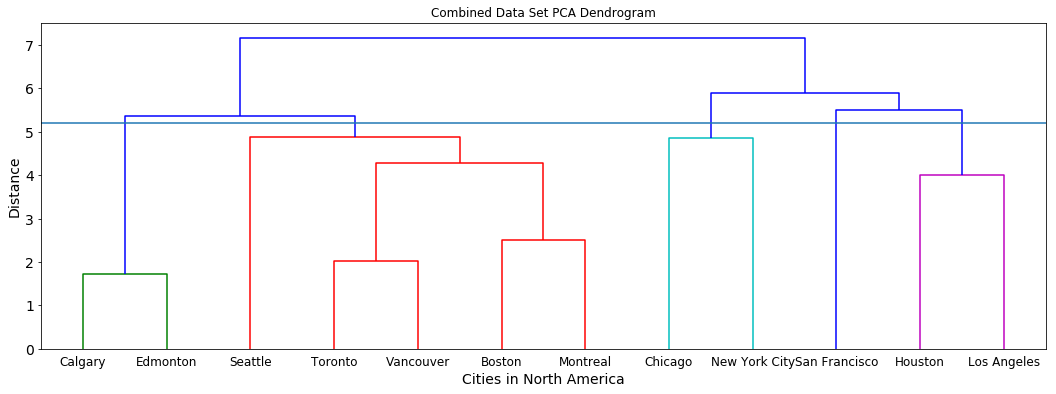

In [43]:
plt.figure(figsize=(18,6))
combined_pca_dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(df_combined_scale, method="ward"),
    labels=df_combined_scale.index
)
plt.title("Combined Data Set PCA Dendrogram")
plt.xlabel("Cities in North America")
plt.ylabel("Distance")
plt.axhline(y=5.2) # Add a line to show which distance

In [44]:
cluster_n_draw_map(df_combined_scale, 5)

               Cluster
Boston               0
Calgary              4
Chicago              2
Edmonton             4
Houston              1
Los Angeles          1
Montreal             0
New York City        2
San Francisco        3
Seattle              0
Toronto              0
Vancouver            0


<a id='Conclusion'></a>

## 4. Conclusion

[Back to Top](#Top)

Climate, Cultural, Demographic all contibue to the cluster of cities in North America. And cities in North America has pretty diverse Characteristics in consider of those information.